# Coursera - Applied Data Science Capstone Project


In this first part of this Notebook, we will describe:

* A description of the problem and a discussion of the background.
* A description of the data and how it will be used to solve the problem.

Later on, we continue to proceed solving the problem posed based on our analysis

## Chapter 1 - Introduction/Business Problem

Consider being someone who would like to move to Toronto or invest in real estate within the Greater Toronto Area, it is often a challenge to identify where the best place buy is. Purchasing real estate is often a big investment and takes up a considerable amount of ones savings. A lot of exploration and research is needed to be able to make an informed decision. Two major consideration factors often involved in real estate purchases are the quality of living within the neighborhood as well as its' housing price "attractive"-ness (especially if the area is undervalued).

We will look into these aspect, with our audience being people who are interested in moving to Toronto.

### Toronto neighborhoods with the Best Quality of Life vs Price

"Quality of Life" is an abstract term. For different people, this can mean different things. In our evaluation, we will take the number of venues within a neighborhood to determine a "Quality of Life" index. Within this index, we will consider the number of essential venues within walking distance of the neighborhood. These venues are defined as:

* Medical Centre (4bf58dd8d48988d104941735)
* Shop & Service (4d4b7105d754a06378d81259)
* Restaurant/Food (4d4b7105d754a06374d81259)
* Outdoor & Recreation (4d4b7105d754a06377d81259)
* Arts & Entertainment (4d4b7104d754a06370d81259)

"Housing price" can vary depending on various factors. This includes many factors such as its' size, type of housing, number of bedrooms, whether it has a garden, etc. As a result, housing prices between neighborhoods can vary greatly based on the type of housing built. To get a better appreciation of how "Attactive" a neighborhood is, we attempt to compare how high the demand for housing is. This takes into consideration factors such as how quickly a listing is sold and how easy it is to sell above the asking price.

By cross referencing the "Quality of Life" for a neighborgood against the "Attractive"-ness, we can better understand and recommend where the best place to settle in Toronto is.

## Chapter 2 - Data

In order to support our investigations, various data sources need to be pooled together. The following are various data sources that we will be leveraging during this exercise. Four Square, GPS Coordinates, and Toronto Demographics data will help us determine the "Quality of Life" of each neighborhood within the Greater Toronto Area. 

Meanwhile Toronto Housing Price data will primary come from Zolo, a real estate listings company in Canada.

### Geolocation Data

**Four Square**

Data from Foursquare provides the venue details based on location data. We will be determining the number of venues of a specific type within a certain distance.

**GPS coordinates of location, place and city**

https://www.gps-latitude-longitude.com/address-to-longitude-latitude-gps-coordinates

Provides useful tools to determine the GPS coordinates of neighborhoods within the Greater Toronto area. The extraction of latitude and longitude information will support us when querying data from Four Square.


### Toronto Housing Price

**Zolo Hottest Toronto Neighborhoods**

https://www.zolo.ca/toronto-real-estate/neighbourhoods

Zolo listing provides several key data for each neighborhood in Toronto in the past 28 days such as: Listing sold under 10 days, listings sold above asking price, average sale price, number of active listings, etc.




## Chapter 3 - Methodology

Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

First we proceed to import all the libraries we will be using
* Numpy
* Pandas
* BeautifulSoup
* Folium
* Matplotlib
* requests
* sklearn

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

from bs4 import BeautifulSoup #import BeautifulSoup for screen scraping

import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

### Chapter 3.1 Attractiveness of Toronto Housing Price by Neighborhood

We first prepare our Toronto Housing data. In this example, I will extract the details provided from Zolo Hottest Toronto Neighborhoods.

In [2]:
#Download Zolo hottest Toronto neighborhoods as a local HTML file
!wget -q -O 'ZoloSoup.html' https://www.zolo.ca/toronto-real-estate/neighbourhoods

In [3]:
with open("ZoloSoup.html") as fp:
    zolosoup = BeautifulSoup(fp)
    
zolosoup = zolosoup.find('section', {'class': 'all-neighborhoods xs-mb5'})

We extract the table header into a list

In [4]:
header=[] #list to store the headers of the table

for h in zolosoup.find_all('th'):
    header.append(h.text)

We also extract the body of the table into a list. The table should contain data that corresponds to the:
* Neighborhood
* Sold under 10 Days
* Sold above asking
* Average sale price
* Active Listings

In [5]:
body=[]

zolosouptable = zolosoup.find('tbody') #We start processing the body of the table
for r in zolosouptable.find_all('tr'):
    newrow=[]
    for d in r.find_all('td'):
        if d.find('a',{'class':'xs-block xs-ml3'}): #Extract the name of the neighborhood
            newrow.append(d.find('a',{'class':'xs-block xs-ml3'}).text)
        else: #Every column except the first in each row
            newrow.append(str(d.text))
    body.append(newrow)


With the details for Neighborhood housing pricing extracted, we can put everything together to build out DataFrame

In [6]:
TorHousing = pd.DataFrame(body,columns=header)
TorHousing.head()

,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings
0,Agincourt North,70%,81%,$714K,16
1,Agincourt South-Malvern West,66%,77%,$642K,21
2,Alderwood,64%,46%,$969K,24
3,Annex,51%,42%,$1.8M,88
4,Banbury-Don Mills,56%,47%,$1.1M,50


#### Exploring and cleaning our Data
We want to explore our data to gain some initial insights, as well as afford the opportunity to perform some data cleansing (e.g.any null values) so as not to influence our analysis.

In [7]:
TorHousing.shape

(143, 5)

In [8]:
TorHousing.dtypes

Neighbourhood (# Rank out of 143)    object
Sold under 10d                       object
Sold above asking                    object
Average sale price                   object
Active listings                      object
dtype: object

With all datatypes=object, we first cleanup our data so we can Cast them into our needed DataTypes

In [9]:
#float(stringPercent.strip('%')) / 100.0

TorHousing.replace('%','',regex=True,inplace=True) #Strip the % signs
TorHousing[header[3]].replace('K','000',regex=True,inplace=True) #convert K to 1000
TorHousing[header[3]].replace('M','000000',regex=True,inplace=True) #convert M to 1,000,000
TorHousing[header[3]].replace("[$]",'',regex=True,inplace=True) #Clean up remaining dollar signs
TorHousing[header[3]].replace("[.]",'',regex=True,inplace=True) #Clean up decimals

TorHousing.head()

,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings
0,Agincourt North,70,81,714000,16
1,Agincourt South-Malvern West,66,77,642000,21
2,Alderwood,64,46,969000,24
3,Annex,51,42,18000000,88
4,Banbury-Don Mills,56,47,11000000,50


Now we can continue casting the DataTypes for our columns

In [10]:
TorHousing[header[1]]=TorHousing[header[1]].apply(pd.to_numeric) #Sold under 10d
TorHousing[header[2]]=TorHousing[header[2]].apply(pd.to_numeric) #Solve above asking
TorHousing[header[3]]=TorHousing[header[3]].apply(pd.to_numeric) #Average sale price
TorHousing[header[-1]]=TorHousing[header[-1]].apply(pd.to_numeric) #Active Listings

TorHousing.dtypes

Neighbourhood (# Rank out of 143)    object
Sold under 10d                        int64
Sold above asking                     int64
Average sale price                    int64
Active listings                       int64
dtype: object

We quickly come to the conclusion that we have captured all neighborhoods as the count and unique values coming from the *describe* output matches

In [11]:
TorHousing.dropna
TorHousing.describe()

,Sold under 10d,Sold above asking,Average sale price,Active listings
count,143.000000,143.000000,1.430000e+02,143.000000
mean,62.265734,59.377622,6.554916e+06,26.594406
std,13.466155,14.749936,7.342469e+06,35.913675
min,21.000000,18.000000,4.070000e+05,1.000000
25%,54.000000,50.000000,7.490000e+05,10.000000
50%,62.000000,60.000000,9.180000e+05,18.000000
75%,70.000000,71.000000,1.200000e+07,29.000000
max,100.000000,92.000000,3.100000e+07,319.000000


### Highest Average Sale Price

Let's sort our dataframe based on the Average sale price to see the Top 10 neighborhoods with the **Highest Average Sale Price**. Here lower average sale price is preferable and hence will be ranked higher. High average sale price may be for a luxury market that not everyone can afford.

In our analysis a lower Average sale price will result in a High score (Rank Value)

In [12]:
#Sort our DataFrames by Average Sale Price and re-index
TorHousing.sort_values(by='Average sale price', ascending=False, axis=0, inplace=True)
TorHousing.reset_index(drop=True, inplace=True)
TorHousing['RankAvgSalePrice']=TorHousing.index #Add the ranking of Average Sale Price as a new column
TorHousing.head(10)

,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings,RankAvgSalePrice
0,Bridle Path-Sunnybrook-York Mills,45,33,31000000,57,0
1,Kingsway South,60,40,25000000,18,1
2,Forest Hill North,80,73,23000000,5,2
3,Forest Hill South,52,29,23000000,28,3
4,Lawrence Park South,67,39,22000000,21,4
5,Casa Loma,35,46,22000000,23,5
6,Bedford Park-Nortown,45,22,22000000,32,6
7,St. Andrew-Windfields,42,29,21000000,57,7
8,Lawrence Park North,76,62,19000000,17,8
9,Annex,51,42,18000000,88,9


What we can learn here, on the high end of the spectrum, neighborhood average sale prices reach 31M CDN.
Next let's visualize the Average Sale price by neighborhood to get a understanding how the distribution is.

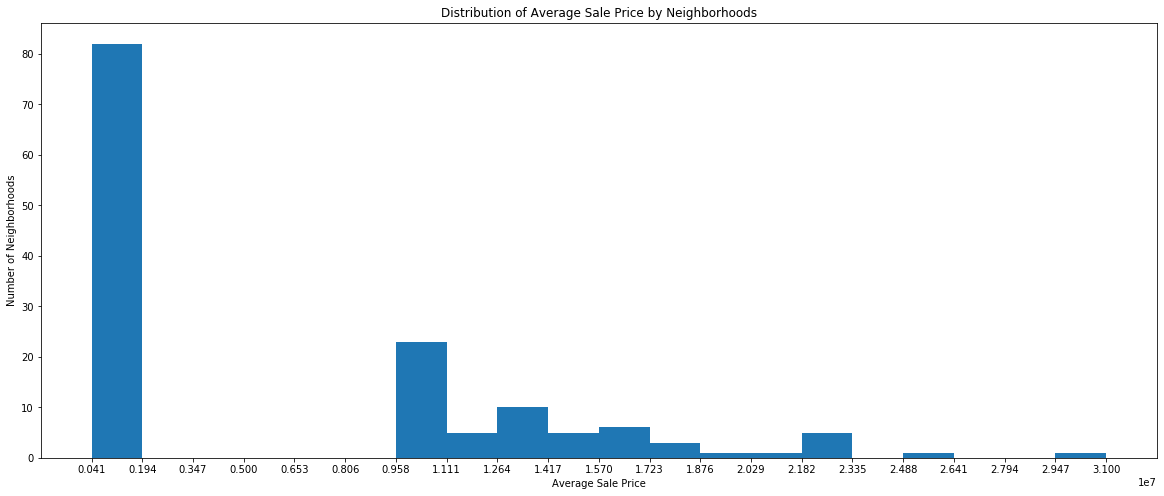

In [13]:
count, bin_edges = np.histogram(TorHousing['Average sale price'],bins=20)
TorHousing['Average sale price'].plot(kind='hist',xticks=bin_edges, figsize=(20,8),bins=20)
plt.title('Distribution of Average Sale Price by Neighborhoods')
plt.xlabel('Average Sale Price')
plt.ylabel('Number of Neighborhoods')
plt.show()

One interesting observation we see when we look into the distibution of Average Sale Price is that in Toronto, there seems to be a significant segregation between luxury vs non-luxury housing markets. 80 of 143 Neighborhoods (~56%) of the Neighbors have an average sale price below 2M CDN. Meanwhile a distinct luxury housing market exists with neighborhoods selling on average of 10M+ CDN.

### Sold under 10 Days

Now let's take a look to see the Top 10 neighborhoods that **Sold Under 10d** A higher percentage of "Sold under 10 Days" gives a higher score (Rank value)

In [14]:
TorHousing.sort_values(by='Sold under 10d', ascending=True, axis=0, inplace=True)
TorHousing.reset_index(drop=True, inplace=True)
TorHousing['RankSoldUnder10d']=TorHousing.index #Add the ranking of Sold under 10d as a new column
TorHousing.head(10)

,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings,RankAvgSalePrice,RankSoldUnder10d
0,Black Creek,21,29,407000,7,142,0
1,Mount Olive-Silverstone-Jamestown,35,41,547000,10,138,1
2,Casa Loma,35,46,22000000,23,5,2
3,Humber Heights,36,48,803000,18,91,3
4,Edenbridge-Humber Valley,36,36,17000000,31,12,4
5,Westminster-Branson,37,43,681000,17,123,5
6,Humberlea-Pelmo Park W4,38,38,949000,4,69,6
7,St. Andrew-Windfields,42,29,21000000,57,7,7
8,Mount Dennis,44,67,697000,9,116,8
9,Hillcrest Village,44,54,882000,14,75,9


Let's visualize the distribution of % Sold under 10 days by Neighborhood

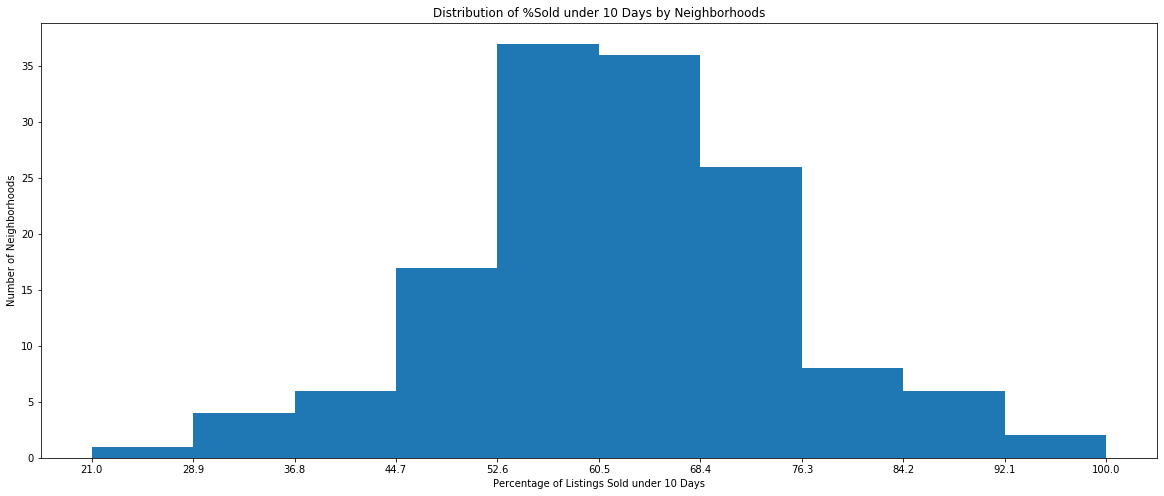

In [15]:
count, bin_edges = np.histogram(TorHousing['Sold under 10d'])
TorHousing['Sold under 10d'].plot(kind='hist',xticks=bin_edges, figsize=(20,8))
plt.title('Distribution of %Sold under 10 Days by Neighborhoods')
plt.xlabel('Percentage of Listings Sold under 10 Days')
plt.ylabel('Number of Neighborhoods')
plt.show()

Looking at the distribution of percent sold under 10 days, we observe a normal curve with an average around 60%. This market sentiment suggests that there is an overall demand for housing within the Toronto area.

### Sold above asking price

Finally we take a look at which neighborhoods have the highest **Sold above asking** price. A Higher sold above asking price gives a high score (Rank)

In [16]:
TorHousing.sort_values(by='Sold above asking', ascending=True, axis=0, inplace=True)
TorHousing.reset_index(drop=True, inplace=True)
TorHousing['RankSoldAboveAsk']=TorHousing.index #Add the ranking of Sold under 10d as a new column
TorHousing.head(10)

,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings,RankAvgSalePrice,RankSoldUnder10d,RankSoldAboveAsk
0,Bathurst Manor,47,18,10000000,24,56,17,0
1,Bedford Park-Nortown,45,22,22000000,32,6,13,1
2,Black Creek,21,29,407000,7,142,0,2
3,Forest Hill South,52,29,23000000,28,3,27,3
4,St. Andrew-Windfields,42,29,21000000,57,7,7,4
5,Bridle Path-Sunnybrook-York Mills,45,33,31000000,57,0,12,5
6,Bayview Woods-Steeles,55,35,12000000,16,36,39,6
7,Princess-Rosethorn,64,36,15000000,20,21,84,7
8,Edenbridge-Humber Valley,36,36,17000000,31,12,4,8
9,South Parkdale,46,38,14000000,10,26,16,9


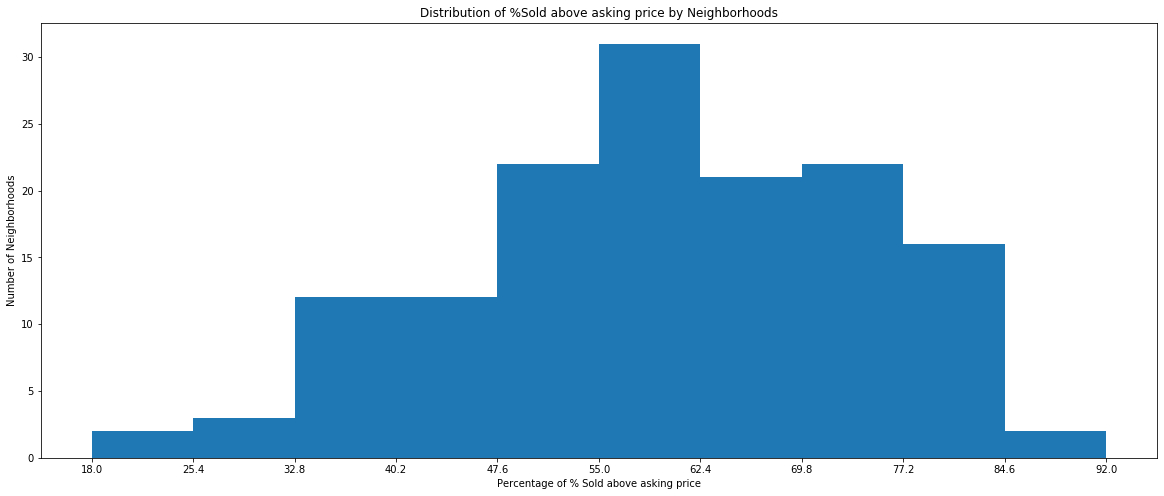

In [17]:
count, bin_edges = np.histogram(TorHousing['Sold above asking'])
TorHousing['Sold above asking'].plot(kind='hist',xticks=bin_edges, figsize=(20,8))
plt.title('Distribution of %Sold above asking price by Neighborhoods')
plt.xlabel('Percentage of % Sold above asking price')
plt.ylabel('Number of Neighborhoods')
plt.show()

Lastly, we calculate a **Aggregate** of the 3 Rankings to measure how "Attractive" housing is in a neighborhood. Our Aggregate score is the sum of our ranks. A higher score is considered better.

In [18]:
TorHousing['Aggregate']=TorHousing.loc[:,'RankAvgSalePrice']+TorHousing.loc[:,'RankSoldUnder10d']+TorHousing.loc[:,'RankSoldAboveAsk']
TorHousing.sort_values(by='Aggregate', ascending=False, axis=0, inplace=True)
TorHousing.reset_index(drop=True, inplace=True)
TorHousing.head(10)


,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings,RankAvgSalePrice,RankSoldUnder10d,RankSoldAboveAsk,Aggregate
0,Humberlea-Pelmo Park W5,69,75,555000,7,137,102,119,358
1,Henry Farm,72,71,597000,23,133,114,107,354
2,Ionview,67,87,686000,2,120,91,141,352
3,Agincourt North,70,81,714000,16,113,104,135,352
4,North St. James Town,100,71,766000,4,102,141,105,348
5,Woburn,68,77,682000,38,122,100,123,345
6,Agincourt South-Malvern West,66,77,642000,21,128,89,124,341
7,Morningside,64,81,682000,10,121,85,132,338
8,Crescent Town,67,78,697000,12,117,92,126,335
9,Bendale,72,73,745000,23,107,113,114,334


According to our Aggregate score, the above shows the Top 10 most attractive neighborhoods from an investment standpoint based on demand, average price, and sales above asking price.

### Chapter 3.2 Quality of Living in Toronto Neighborhoods

#### Finding Longitude and Latitude of Toronto Neighborhoods

We next attempt to identify the latitude and longitude of our Toronto Neighborhoods

In [19]:
TorLatLon=pd.read_csv("CapstoneTorLatLon.csv", header=None)
TorLatLon.columns=['Neighborhood','Longitude','Latitude']
TorLatLon.head()

,Neighborhood,Longitude,Latitude
0,Bridle Path-Sunnybrook-York Mills,-79.371899,43.735914
1,Kingsway South,-79.507194,43.652674
2,Lawrence Park South,-79.411687,43.712137
3,Casa Loma,-79.410363,43.676843
4,Forest Hill North,-79.426376,43.705249


In [20]:
TorLatLon.dtypes

Neighborhood     object
Longitude       float64
Latitude        float64
dtype: object

In [21]:
TorLatLon.describe()

,Longitude,Latitude
count,143.000000,143.000000
mean,-79.396350,43.709256
std,0.104319,0.051655
min,-79.625844,43.593421
25%,-79.471283,43.671249
50%,-79.400403,43.703714
75%,-79.319295,43.748931
max,-79.148327,43.825998


Let's plot our neighborhoods in a Toronto map to better understand their relative locations within the Greater Toronto Area

In [22]:
# set number of clusters
kclusters = 1

# create map
map_clusters = folium.Map(location=[43.654, -79.384], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi in zip(TorLatLon['Latitude'], TorLatLon['Longitude'], TorLatLon['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker([lat, lon],
                        radius=5,
                        popup=label).add_to(map_clusters)

map_clusters

Based on our map above, it seems we have a rather good distribution and coverage of Neighborhoods within the Greater Toronto Area.

### Leveraging Four Square Venue data to determine the Quality of Life in each Neighborhood

Here on, we will try to retrieve the number of different venues around each Neighborhood as input for determining our "Quality of Life" index. As we described in **Chapter 1**, for simplicity we measure Quality of Life based on the number of following venues within range of a neighborhood (FourSquare category ID):

* Medical Centre (4bf58dd8d48988d104941735)
* Shop & Service (4d4b7105d754a06378d81259)
* Restaurant/Food (4d4b7105d754a06374d81259)
* Outdoor & Recreation (4d4b7105d754a06377d81259)
* Arts & Entertainment (4d4b7104d754a06370d81259)

#### Define our Foursquare credientials and version

In [23]:
CLIENT_ID = 'LWBLVJTTJEUADSXBRDHMULPFW1IPS2ILKH5OVCEC3APXID2V' # your Foursquare ID
CLIENT_SECRET = '3ZQD1L3FLFAVEH4GSWYKA2KOU0B50QWNIX5OMXFKR5IRDYWS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LWBLVJTTJEUADSXBRDHMULPFW1IPS2ILKH5OVCEC3APXID2V
CLIENT_SECRET:3ZQD1L3FLFAVEH4GSWYKA2KOU0B50QWNIX5OMXFKR5IRDYWS


We also define a list of the Category IDs that are of interest to us

In [24]:
#Define a list of FourSquare CategoryIDs to shortlist the venues we are interested in
CategoryList=['4bf58dd8d48988d104941735','4d4b7105d754a06378d81259','4d4b7105d754a06374d81259','4d4b7105d754a06377d81259','4d4b7104d754a06370d81259']
CategoryHeader=['Neighborhood','Medical','Shops','Food','Recreation','Arts']

We define the radius to search to be within a 1000m radius and to limit to 100 results

In [25]:
radius=1000
LIMIT=100

Let's define a function that will allow us to determine the venues of a specific category based on it's location

In [26]:
def findcat(Neightborhood, Lat, Lng, Catid):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT,
        Catid)

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    venues_list=[]

    # return only relevant information for each nearby venue
    venues_list.append([(
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])
    
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
    
    return nearby_venues

We then loop through our list of Neighborhoods to count the number of venues for each category. This is a time intensive step as essentially we are making several requests to the Four Square API by neighborhood by venue category. While extracting venue category is a Regular API Call, the request/get takes time and varies depending on network conditions.

In [41]:
body=[]

#We have to change this to our fill TorLatLon later one
testset=TorLatLon.copy()

print('Checking venues for the following neighborhoods...(Please wait)')
for neighborhood, lng, lat in zip(testset['Neighborhood'],testset['Longitude'],testset['Latitude']):
    print(neighborhood)
    newrow=[neighborhood]
    for cat in CategoryList:
        try:
            newrow.append(len(findcat(neighborhood,lat,lng,cat)))
        except:
            newrow.append('0')
    body.append(newrow)

Checking venues for the following neighborhoods...(Please wait)
Bridle Path-Sunnybrook-York Mills
Kingsway South
Lawrence Park South
Casa Loma
Forest Hill North
Forest Hill South
St. Andrew-Windfields
Bedford Park-Nortown
Lawrence Park North
Annex
Wychwood
Rosedale-Moore Park
Princess-Rosethorn
North Riverdale
Mount Pleasant East
Yonge-St. Clair
Palmerston-Little Italy
Playter Estates-Danforth
Edenbridge-Humber Valley
Trinity-Bellwoods
South Parkdale
Lansing-Westgate
Humewood-Cedarvale
Lambton Baby Point
Leaside
The Beaches
Runnymede-Bloor West Village
Newtonbrook West
Danforth
Roncesvalles
High Park North
Yonge-Eglinton
Bayview Woods-Steeles
Blake-Jones
East York
Englemount-Lawrence
Greenwood-Coxwell
High Park-Swansea
Willowdale West
Banbury-Don Mills
Oakwood-Vaughan
Highland Creek
Maple Leaf
Broadview North
Rouge E10
Rustic
Parkwoods-Donalda
Newtonbrook East
Willowridge-Martingrove-Richview
Woodbine Corridor
South Riverdale
Woodbine-Lumsden
Corso Italia-Davenport
Danforth Village-Eas

In [30]:
#Comment/out the below line if you want to read from the FourSquare generated data
QOL=pd.DataFrame(body,columns=CategoryHeader)

#Comment/out the below 2 lines if you want to read the pre-generated FourSquare data from CSV
#QOL=pd.read_csv("QOL.csv")
#QOL.drop(['Unnamed: 0'],axis=1,inplace=True)

QOL

,Neighborhood,Medical,Shops,Food,Recreation,Arts,QOL
0,Bridle Path-Sunnybrook-York Mills,4,1,6,2,1,14
1,Kingsway South,6,22,24,5,7,64
2,Lawrence Park South,7,34,38,18,1,98
3,Casa Loma,14,37,50,20,5,126
4,Forest Hill North,8,17,26,10,3,64
5,Forest Hill South,1,10,12,13,5,41
6,St. Andrew-Windfields,5,4,3,3,3,18
7,Bedford Park-Nortown,4,29,15,8,1,57
8,Lawrence Park North,6,4,4,7,1,22
9,Annex,33,64,100,35,13,245


In [31]:
QOL.dtypes

Neighborhood    object
Medical          int64
Shops            int64
Food             int64
Recreation       int64
Arts             int64
QOL              int64
dtype: object

In [32]:
QOL['Medical']=QOL['Medical'].apply(pd.to_numeric)
QOL['Shops']=QOL['Shops'].apply(pd.to_numeric)
QOL['Food']=QOL['Food'].apply(pd.to_numeric)
QOL['Recreation']=QOL['Recreation'].apply(pd.to_numeric)
QOL['Arts']=QOL['Arts'].apply(pd.to_numeric)

QOL.dtypes

Neighborhood    object
Medical          int64
Shops            int64
Food             int64
Recreation       int64
Arts             int64
QOL              int64
dtype: object

In [33]:
QOL['QOL']=QOL.loc[:,'Medical']+QOL.loc[:,'Shops']+QOL.loc[:,'Food']+QOL.loc[:,'Recreation']+QOL.loc[:,'Arts']
QOL.describe()

,Medical,Shops,Food,Recreation,Arts,QOL
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,10.097902,30.790210,31.503497,12.930070,5.832168,91.153846
std,12.326723,25.662175,31.571487,16.479458,9.607792,87.876699
min,0.000000,1.000000,1.000000,1.000000,0.000000,13.000000
25%,4.000000,11.000000,8.000000,4.000000,1.000000,30.000000
50%,6.000000,22.000000,17.000000,6.000000,3.000000,57.000000
75%,10.000000,44.500000,49.000000,14.500000,5.500000,127.000000
max,65.000000,100.000000,100.000000,81.000000,61.000000,407.000000


#### Exploring our Quality of Life index by Neighborhood

Next we are going to explore which Neighborhoods scored well on our Quality of Life index

In [34]:
# set number of clusters
kclusters = 5

#We only take a Dataframe with our Quality of Life Index
mapqol=QOL.copy()
mapqol[['Neighborhood','QOL']]

,Neighborhood,QOL
0,Bridle Path-Sunnybrook-York Mills,14
1,Kingsway South,64
2,Lawrence Park South,98
3,Casa Loma,126
4,Forest Hill North,64
5,Forest Hill South,41
6,St. Andrew-Windfields,18
7,Bedford Park-Nortown,57
8,Lawrence Park North,22
9,Annex,245


Let's now label the Quality of Life index of each neighborhood into equally spaced bins. Our total number of bins to cluster our neighborhoods are based on kclusters. We save the result into a new column of the Dataframe called 'Clusters'

In [35]:
mapqol['Cluster']=""
mycluster=range(mapqol['QOL'].min(),mapqol['QOL'].max(),int((mapqol['QOL'].max()-mapqol['QOL'].min())/kclusters))
for x in range(0,mapqol.shape[0],1):
    counter=0
    for y in mycluster:
        if (mapqol.iloc[x,6]>=y):
            mapqol.iloc[x,7]=counter
        counter=counter+1

In [36]:
mapqol['Cluster']=mapqol['Cluster'].apply(pd.to_numeric)
mapqol.head()

,Neighborhood,Medical,Shops,Food,Recreation,Arts,QOL,Cluster
0,Bridle Path-Sunnybrook-York Mills,4,1,6,2,1,14,0
1,Kingsway South,6,22,24,5,7,64,0
2,Lawrence Park South,7,34,38,18,1,98,1
3,Casa Loma,14,37,50,20,5,126,1
4,Forest Hill North,8,17,26,10,3,64,0


Next we need to add our Latitude and Longitude details into our mapqol dataframe in preparation for Folium

In [37]:
mapqol=mapqol.merge(TorLatLon,how='left',left_on="Neighborhood",right_on="Neighborhood")
mapqol.head()

,Neighborhood,Medical,Shops,Food,Recreation,Arts,QOL,Cluster,Longitude,Latitude
0,Bridle Path-Sunnybrook-York Mills,4,1,6,2,1,14,0,-79.371899,43.735914
1,Kingsway South,6,22,24,5,7,64,0,-79.507194,43.652674
2,Lawrence Park South,7,34,38,18,1,98,1,-79.411687,43.712137
3,Casa Loma,14,37,50,20,5,126,1,-79.410363,43.676843
4,Forest Hill North,8,17,26,10,3,64,0,-79.426376,43.705249


In [38]:
mapqol.dtypes

Neighborhood     object
Medical           int64
Shops             int64
Food              int64
Recreation        int64
Arts              int64
QOL               int64
Cluster           int64
Longitude       float64
Latitude        float64
dtype: object

With our Cluster defined, we are now ready to map each Neighborhood based on it's Cluster onto a Folium Map to see where the best QOL Neighborhoods are.

In [39]:
# create map
map_qolcluster = folium.Map(location=[43.654, -79.384], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mapqol['Latitude'], mapqol['Longitude'], mapqol['Neighborhood'], mapqol['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_qolcluster)
       
map_qolcluster

The results from the map above show in general the closer you are to Downtown Toronto, the higher the likelihood of a venue being available (e.g. restaurants, shops, medical facilities, etc.) Likewise the farther away you live from downtown Toronto, the scarcer such venues become. This trend is not surprising and correlates very closely to what one would expect.

### Chapter 3.3 Piecing everything together...

Now that we have our dataframe GPS Coordinates as well as our Quality of Life by neightborhood, let's put it all together.

We try to combine the details that we extracted into our Dataframe. First we check the shape of our dataframes to make sure there is no mismatch. Each Dataframe of our source data should comtain the same number of rows

In [40]:
print(TorHousing.shape)
print(QOL.shape)
print(TorLatLon.shape)

(143, 9)
(143, 7)
(143, 3)


We first make copies of each of our 3 Datasets. This is to prevent any unintended overwritting and needs to trigger more FourSquare requests or re-downloads of our dataset

In [41]:
mytordf=TorHousing.copy()
mytorqol=QOL.copy()
mytorll=TorLatLon.copy()

#Save mytorqol to CSV as this is the most expensive transaction
mytorqol.to_csv("QOL.csv")

Let's double check the sizes of our new dataframes again

In [42]:
print(mytordf.shape)
print(mytorqol.shape)
print(mytorll.shape)

(143, 9)
(143, 7)
(143, 3)


#### Merging our Housing price data with the GPS coordinates

We run our Panda Dataframe merge to combine two dataframes together. With a common key being the "Neighborhood", we drop the duplicate column after the merge.

In [43]:
mytordf=mytordf.merge(mytorll,how="left",left_on="Neighbourhood (# Rank out of 143)",right_on="Neighborhood")
mytordf.drop(['Neighborhood'],axis=1,inplace=True)
mytordf.head()

,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings,RankAvgSalePrice,RankSoldUnder10d,RankSoldAboveAsk,Aggregate,Longitude,Latitude
0,Humberlea-Pelmo Park W5,69,75,555000,7,137,102,119,358,-79.533217,43.721319
1,Henry Farm,72,71,597000,23,133,114,107,354,-79.346524,43.769583
2,Ionview,67,87,686000,2,120,91,141,352,-79.273900,43.730824
3,Agincourt North,70,81,714000,16,113,104,135,352,-79.266502,43.808053
4,North St. James Town,100,71,766000,4,102,141,105,348,-79.373306,43.670867


#### Further merging with our Quality of Life data

Again the common key here is the Neighborhood. We take this and run through our Dataframe Merge as we did before.

In [44]:
#Merge MYTORDF with QOL Dataframe
mytordf=mytordf.merge(mytorqol,how="left",left_on="Neighbourhood (# Rank out of 143)", right_on="Neighborhood")
mytordf.drop(['Neighborhood'],axis=1,inplace=True)
mytordf.head(10)

,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings,RankAvgSalePrice,RankSoldUnder10d,RankSoldAboveAsk,Aggregate,Longitude,Latitude,Medical,Shops,Food,Recreation,Arts,QOL
0,Humberlea-Pelmo Park W5,69,75,555000,7,137,102,119,358,-79.533217,43.721319,2,13,4,2,0,21
1,Henry Farm,72,71,597000,23,133,114,107,354,-79.346524,43.769583,7,100,30,6,18,161
2,Ionview,67,87,686000,2,120,91,141,352,-79.273900,43.730824,12,25,13,4,1,55
3,Agincourt North,70,81,714000,16,113,104,135,352,-79.266502,43.808053,5,25,15,2,2,49
4,North St. James Town,100,71,766000,4,102,141,105,348,-79.373306,43.670867,33,77,100,34,8,252
5,Woburn,68,77,682000,38,122,100,123,345,-79.231728,43.776470,5,14,16,3,2,40
6,Agincourt South-Malvern West,66,77,642000,21,128,89,124,341,-79.242296,43.789964,13,15,21,6,5,60
7,Morningside,64,81,682000,10,121,85,132,338,-79.204997,43.782666,7,11,4,4,1,27
8,Crescent Town,67,78,697000,12,117,92,126,335,-79.293736,43.695981,6,47,17,4,6,80
9,Bendale,72,73,745000,23,107,113,114,334,-79.248935,43.765434,0,5,7,1,1,14


At this stage, we have finally merged all our data into a single DataFrame. As a recap, this Dataframe now consists of:
* A list of Neighborhoods in Toronto
* Housing price information of each Neighborhood (e.g. Average Sale Price)
* GPS coordinates of each Neighborhood in Toronto
* A count of the number of Medical, Shops, Food, Recreation and Arts venues within 1km of each Neighborhood

## Chapter 4 - Results

Results section where you discuss the results.

Analysis to perform:
* Aggregate vs QOL distribution - K Means Clustering
* Others??

### Analysing the relationship between Housing and Quality of Life

We perform some analysis on our obtained data

In [45]:
Tor_QOL_df=mytordf[['Aggregate','QOL']]
Tor_QOL_df.head()

,Aggregate,QOL
0,358,21
1,354,161
2,352,55
3,352,49
4,348,252


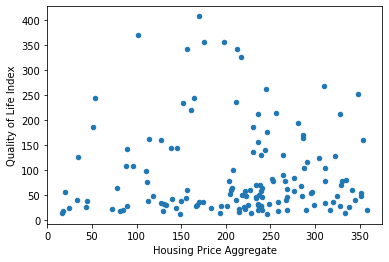

In [46]:
Tor_QOL_df.plot(kind='scatter',x='Aggregate',y='QOL')
plt.xlabel('Housing Price Aggregate')
plt.ylabel('Quality of Life Index')
plt.show()

From this distribution, we come to easily recognize that there is not a direct linear relationship between our Quality of Life index, with the Housing Price Aggregate. In otherwords, we can find neighborhoods that fair rather well in terms of our Housing Price aggregate even with a very low level of our Quality of Life. This tells us that performing supervised learning models such as Linear Regression would not be a good approach for our analysis.

Based on this, we decide to use unsupervised learning techniques such as clustering to see if we could group Neighborhoods into different categories. We begin with 5 clusters and perform K Means clustering for further assessment.

Our first step is to label each individual neighborhood amongst 5 different clusters and add this label to our dataframe

In [47]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tor_QOL_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 4, 1,
       1, 4, 1, 1, 1, 4, 1, 4, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 4,
       1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 4, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [48]:
# add clustering labels
Tor_QOL_df.insert(2, 'Cluster Labels', kmeans.labels_)
Tor_QOL_df.insert(3, 'Neighborhood', mytordf['Neighbourhood (# Rank out of 143)'])
Tor_QOL_df.insert(4, 'Latitude', mytordf['Latitude'])
Tor_QOL_df.insert(5, 'Longitude', mytordf['Longitude'])

Tor_QOL_df.head() # check the last columns!

,Aggregate,QOL,Cluster Labels,Neighborhood,Latitude,Longitude
0,358,21,3,Humberlea-Pelmo Park W5,43.721319,-79.533217
1,354,161,4,Henry Farm,43.769583,-79.346524
2,352,55,3,Ionview,43.730824,-79.273900
3,352,49,3,Agincourt North,43.808053,-79.266502
4,348,252,4,North St. James Town,43.670867,-79.373306


Now that we've done our K Means Clustering, let's plot again our Scatterplot to see which Neighborhoods belong to the same cluster.

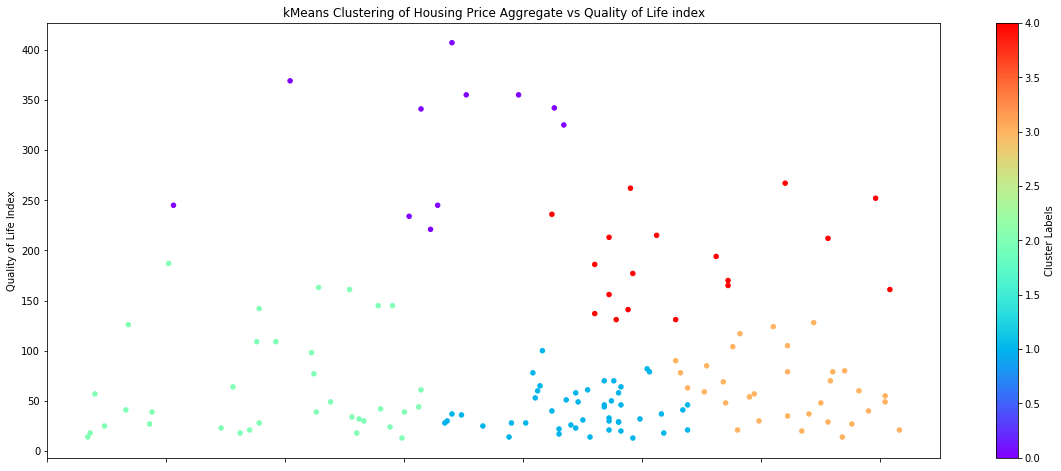

In [58]:
Tor_QOL_df.plot(kind='scatter',x='Aggregate',y='QOL',c='Cluster Labels',cmap=cm.rainbow,figsize=(20,8))
plt.xlabel('Housing Price Aggregate')
plt.ylabel('Quality of Life Index')
plt.title('kMeans Clustering of Housing Price Aggregate vs Quality of Life index')
plt.show()

#### Understanding our different Clusters

Let's try to understand what these different clusters mean. **Cluster 0** can be summarized as those neighborhoods with:
* Highest Quality of Living (Good)
* Modest Housing Price Aggregate (Balanced)

In [66]:
print("Number of Neighborhoods " + str(Tor_QOL_df[Tor_QOL_df['Cluster Labels']==0].shape[0]))
Tor_QOL_df[Tor_QOL_df['Cluster Labels']==0].head()

Number of Neighborhoods 11


,Aggregate,QOL,Cluster Labels,Neighborhood,Latitude,Longitude
80,217,325,0,Kensington-Chinatown,43.653943,-79.400403
83,213,342,0,Moss Park,43.654789,-79.372602
92,198,355,0,Waterfront Communities C8,43.641648,-79.377921
96,176,355,0,Waterfront Communities C1,43.641648,-79.377921
99,170,407,0,University,43.652420,-79.387101


**Cluster 1** represents the neighborhoods with the:
* Lowest Quality of Living index (Bad)
* Modest House Pricing Aggregate (Balanced)

In [67]:
print("Number of Neighborhoods " + str(Tor_QOL_df[Tor_QOL_df['Cluster Labels']==1].shape[0]))
Tor_QOL_df[Tor_QOL_df['Cluster Labels']==1].head()

Number of Neighborhoods 47


,Aggregate,QOL,Cluster Labels,Neighborhood,Latitude,Longitude
36,269,21,1,Humbermede,43.738994,-79.539408
37,269,46,1,Steeles,43.816214,-79.314549
39,267,41,1,Glenfield-Jane Heights,43.706822,-79.304340
43,259,18,1,Willowridge-Martingrove-Richview,43.676158,-79.569572
44,258,37,1,Rexdale-Kipling,43.719857,-79.570600


**Cluster 2** represents neighborhoods with:
* Low Quality of Living (Bad)
* Poor Housing Price Aggregate (Bad)

In [68]:
print("Number of Neighborhoods " + str(Tor_QOL_df[Tor_QOL_df['Cluster Labels']==2].shape[0]))
Tor_QOL_df[Tor_QOL_df['Cluster Labels']==2].head()

Number of Neighborhoods 35


,Aggregate,QOL,Cluster Labels,Neighborhood,Latitude,Longitude
104,157,61,2,Stonegate-Queensway,43.630505,-79.484345
106,156,44,2,Mount Olive-Silverstone-Jamestown,43.741149,-79.589238
108,150,39,2,Westminster-Branson,43.785580,-79.451092
109,149,13,2,Bayview Village,43.778243,-79.382758
110,145,145,2,Willowdale East,43.771171,-79.419750


**Cluster 3** represents neighborhoods that have a:
* Relatively lower Quality of Living (Bad)
* High Housing Price Aggregate (Good)

In [69]:
print("Number of Neighborhoods " + str(Tor_QOL_df[Tor_QOL_df['Cluster Labels']==3].shape[0]))
Tor_QOL_df[Tor_QOL_df['Cluster Labels']==3].head()

Number of Neighborhoods 32


,Aggregate,QOL,Cluster Labels,Neighborhood,Latitude,Longitude
0,358,21,3,Humberlea-Pelmo Park W5,43.721319,-79.533217
2,352,55,3,Ionview,43.730824,-79.273900
3,352,49,3,Agincourt North,43.808053,-79.266502
5,345,40,3,Woburn,43.776470,-79.231728
6,341,60,3,Agincourt South-Malvern West,43.789964,-79.242296


**Cluster 4** represents those neighborhoods that have a:
* Modest Quality of Life Index (Balanced)
* High Housing Price Aggregate (Good)

In [70]:
print("Number of Neighborhoods " + str(Tor_QOL_df[Tor_QOL_df['Cluster Labels']==4].shape[0]))
Tor_QOL_df[Tor_QOL_df['Cluster Labels']==4].head()

Number of Neighborhoods 18


,Aggregate,QOL,Cluster Labels,Neighborhood,Latitude,Longitude
1,354,161,4,Henry Farm,43.769583,-79.346524
4,348,252,4,North St. James Town,43.670867,-79.373306
12,328,212,4,South Riverdale,43.660603,-79.350340
21,310,267,4,Niagara,43.637383,-79.408493
29,286,170,4,Roncesvalles,43.646317,-79.449068


Summarizing our different Clusters, we see:

|Cluster | Quality of Life Index | Housing Price Aggregate | Recommended?|
|---|---|---|---|
|Cluster 0| Good | Balanced| Yes |
|Cluster 1|Bad | Balanced| No|
|Cluster 2|Bad | Bad| No|
|Cluster 3|Bad | Good| No|
|Cluster 4|Balanced | Good| Yes|

With our clustering, we further take a look at each Cluster to see not only which neighborhoods, but more important where are the most attractive options.

In [75]:
# create map
Tor_QOL_map = folium.Map(location=[43.654, -79.384], zoom_start=11)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tor_QOL_df['Latitude'], Tor_QOL_df['Longitude'], Tor_QOL_df['Neighborhood'], Tor_QOL_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Tor_QOL_map)



    
Tor_QOL_map

Cluster 0 - Red, Cluster 1 - Purpose, Cluster 2 - Blue, Cluster 3 - Green, Cluster 4 - Orange

## Chapter 5 - Discussion 

Section where you discuss any observations you noted and any recommendations you can make based on the results.

First, let's add our Cluster Labels onto our overall DataFrame (mytordf)

In [79]:
#Merge MYTORDF with Tor_QOL_map Dataframe
mytordf=mytordf.merge(Tor_QOL_df[['Neighborhood','Cluster Labels']],how="left",left_on="Neighbourhood (# Rank out of 143)", right_on="Neighborhood")
mytordf.drop(['Neighborhood'],axis=1,inplace=True)
mytordf.head(5)


,Neighbourhood (# Rank out of 143),Sold under 10d,Sold above asking,Average sale price,Active listings,RankAvgSalePrice,RankSoldUnder10d,RankSoldAboveAsk,Aggregate,Longitude,Latitude,Medical,Shops,Food,Recreation,Arts,QOL,Cluster Labels
0,Humberlea-Pelmo Park W5,69,75,555000,7,137,102,119,358,-79.533217,43.721319,2,13,4,2,0,21,3
1,Henry Farm,72,71,597000,23,133,114,107,354,-79.346524,43.769583,7,100,30,6,18,161,4
2,Ionview,67,87,686000,2,120,91,141,352,-79.273900,43.730824,12,25,13,4,1,55,3
3,Agincourt North,70,81,714000,16,113,104,135,352,-79.266502,43.808053,5,25,15,2,2,49,3
4,North St. James Town,100,71,766000,4,102,141,105,348,-79.373306,43.670867,33,77,100,34,8,252,4
5,Woburn,68,77,682000,38,122,100,123,345,-79.231728,43.776470,5,14,16,3,2,40,3
6,Agincourt South-Malvern West,66,77,642000,21,128,89,124,341,-79.242296,43.789964,13,15,21,6,5,60,3
7,Morningside,64,81,682000,10,121,85,132,338,-79.204997,43.782666,7,11,4,4,1,27,3
8,Crescent Town,67,78,697000,12,117,92,126,335,-79.293736,43.695981,6,47,17,4,6,80,3
9,Bendale,72,73,745000,23,107,113,114,334,-79.248935,43.765434,0,5,7,1,1,14,3


Next we isolate and look at only Neighborhoods that fall under Cluster 0 and Cluster 4

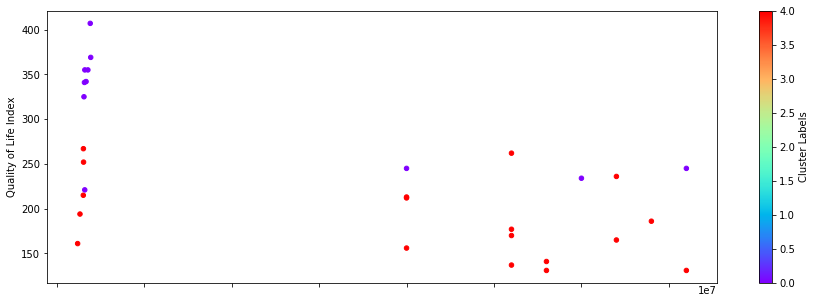

In [140]:
x=mytordf[(mytordf['Cluster Labels']==4)]
x=x.append(mytordf[(mytordf['Cluster Labels']==0)])
x.plot(kind='scatter', x='Average sale price',y='QOL', c='Cluster Labels',cmap=cm.rainbow,figsize=(15,5))
plt.xlabel('Average sale price')
plt.ylabel('Quality of Life Index')
plt.show()

A quick plot shows that we have a large portion of neighborhoods that fall into the Luxury Market with Average sale price > 10M. Hence we want to isolate those Neighborhoods with an **Average sale price** less than 1M; at least they are relatively more "affordable"

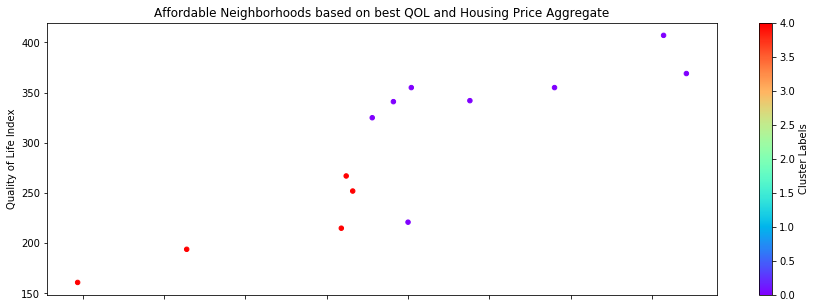

In [141]:
x=x[x['Average sale price']<1000000].copy()
x.sort_values(by='Average sale price', ascending=True, axis=0, inplace=True)
x.plot(kind='scatter', x='Average sale price',y='QOL', c='Cluster Labels',cmap=cm.rainbow,figsize=(15,5))
plt.xlabel('Average Sale Price')
plt.ylabel('Quality of Life Index')
plt.title('Affordable Neighborhoods based on best QOL and Housing Price Aggregate')
plt.show()

Finally we want to plot on the map to show where are the best and most affordable places to live in Toronto

In [139]:
Affordable_Tor_QOL_map = folium.Map(location=[43.654, -79.384], zoom_start=13)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, price in zip(x['Latitude'], x['Longitude'], x['Neighbourhood (# Rank out of 143)'], x['Cluster Labels'], x['Average sale price']):
    label = folium.Popup(str(poi) + ', Average sale price: $' + str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Affordable_Tor_QOL_map)
    
Affordable_Tor_QOL_map

Based on the data we have collected, we are not ready to give our final recommendation.

**Recommendation 1** Sub 1M Neighborhoods with highest QOL & Housing price aggregate

In [137]:
x[['Neighbourhood (# Rank out of 143)','Average sale price']].tail(3)


,Neighbourhood (# Rank out of 143),Average sale price
92,Waterfront Communities C8,890000
99,University,957000
124,Bay Street Corridor,971000


**Recommendation 2** Most affordable Neighborgoods with highest QOL & Housing price aggregate

In [138]:
x[['Neighbourhood (# Rank out of 143)','Average sale price']].head(3)

,Neighbourhood (# Rank out of 143),Average sale price
1,Henry Farm,597000
33,Regent Park,664000
45,Little Portugal,759000


## Chapter 6 - Conclusion


Based on our analysis the best Neighborhoods to settle down on depends on what you are looking for. Our analysis results recommend Neighborhoods that fall under our "Cluster 0" or "Cluster 4" classifications. In general, they have a net positive rating in terms of both Quality of Life and scored considerably well in our Housing Price Aggregate.

It is worthwhile to highlight here again that our Housing Price Aggregate takes into consideration of how fast listings are being sold, and how many listings were sold above the asking price. This gives us a measure into how attractive a neighborhood is in general and serves as an indication of a good investment. The average price of the neighborhood is also factored into this aggregate where we favor more affordable housing over the luxury market.

Meanwhile, our analysis also interestingly described where not to invest. This could be classified as those neighborhoods under Cluster 2 and 3. These are often neighborhoods where we either have very few essential venues or did not comparatively fair well in terms of our housing price aggregate. This does not mean they are not good neighborhoods to live in, as our aggregate is only a comparative indication.


To better our analysis, it would have been worthwhile to further dive into how we should define the "Quaity of Life" index. In our analysis, we made a very crude approximation based on the number of essential venues within a one kilometer radius from the centre of each neighborhood. This made many approximations that may have biased our analysis:

* Neighborhoods are seldom circular
* The Center of some neighborhoods are very close to each other leading to overlaps between the 1km radius
* Many people in Canada drives a car, is 1km a meaningful radius given how accessible other parts of a city is

Furthermore, different people have different life styles. Some prefer to live within the heart of the city where the lifestyle is vibrant and lots of things going on. Meanwhile others prefer to live in a quiet neighborhood with a close proximity to parks and nature. As a result, dependant on your personal life choices multiple recommendations could be made


To better improve our analysis, further datasets could be used to better understand further features that could refine our analysis. The City of Toronto via it's Open Data Portal offers many details of each neighborhood that could be further factored in (https://open.toronto.ca/dataset/neighbourhood-profiles/) This includes for instance:

* Housing profiles within each neighborhood (number of condos, number of semi-detached houses, etc.)
* Ethnicity and language spoken most in each neighborhood
* Marital status and family size
* Education level and breakdown
* Income level

Lastly, with a rich dataset available, instead of making assumptions the analysis could be better tailored by taking input from the anyone using these results to better guide and define what is considered his/her priorities in life. This could help adjust weights given to each feature to better tailor the results for different needs.